In [1]:
# imports
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from esem import gp_model
from eofs.xarray import Eof
from utils import *
import gpflow

2024-11-22 05:30:38.445843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732278638.457860  251654 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732278638.461740  251654 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 05:30:38.476337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# list of experiment data used for training

train_files= ['ssp126', 'ssp370', 'ssp585', 'historical', 'hist-GHG', 'hist-aer']

### prepare data

In [ ]:
# get data
Xtrain, eof_solvers = create_predictor_data(train_files)
Ytrain_dtr = create_predictdand_data(train_files)['diurnal_temperature_range'].values.reshape(-1, 96*144)

Xtest = get_test_data('ssp245', eof_solvers)
Ytest = xr.open_dataset('../test/outputs_ssp245.nc').compute()
dtr_truth = Ytest['diurnal_temperature_range'].mean('member')

In [4]:
# drop rows including nans
train_nan_mask = Xtrain.isna().any(axis=1).values
Xtrain = Xtrain.dropna(axis=0, how='any')
Ytrain_dtr = Ytrain_dtr[~train_nan_mask]
assert Xtrain.shape[0]==Ytrain_dtr.shape[0]

test_nan_mask = Xtest.isna().any(axis=1).values
Xtest = Xtest.dropna(axis=0, how='any')
dtr_truth = dtr_truth[~test_nan_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = Xtrain['CO2'].mean(), Xtrain['CO2'].std()
train_CH4_mean, train_CH4_std = Xtrain['CH4'].mean(), Xtrain['CH4'].std()

Xtrain['CO2'] = (Xtrain['CO2'] - train_CO2_mean) / train_CO2_std
Xtrain['CH4'] = (Xtrain['CH4'] - train_CH4_mean) / train_CH4_std

Xtest['CO2'] = (Xtest['CO2'] - train_CO2_mean) / train_CO2_std
Xtest['CH4'] = (Xtest['CH4'] - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_dtr_mean, train_dtr_std = Ytrain_dtr.mean(), Ytrain_dtr.std()
Ytrain_dtr = (Ytrain_dtr - train_dtr_mean) / train_dtr_std

### Model

In [7]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0]) # active_dims specifies which dimension the kernel is applied to
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

I0000 00:00:1732278647.319994  251654 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [8]:
np.random.seed(5)

"""
In Gaussian Processes, a mean function represents the "prior mean" or the expected value
of the function at any input point before observing any data.
"""
mean = gpflow.mean_functions.Constant()

model = gpflow.models.GPR(data=(Xtrain.astype(np.float64), # cast to float64 because gpflow requires numerical stability
                                Ytrain_dtr.astype(np.float64)),
                          kernel = kernel,
                          mean_function = mean)

In [9]:
# define optimizer
optimizer = gpflow.optimizers.Scipy()

# train
optimizer.minimize(model.training_loss,
                   variables=model.trainable_variables,
                   options=dict(disp=True, maxiter=1000))

I0000 00:00:1732278651.883347  251719 cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x55b88c9a98e0
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26854D+07    |proj g|=  1.84502D+06

At iterate    1    f=  1.11613D+07    |proj g|=  8.94905D+05

At iterate    2    f=  1.09653D+07    |proj g|=  1.25952D+05

At iterate    3    f=  1.09480D+07    |proj g|=  1.22959D+05

At iterate    4    f=  1.08528D+07    |proj g|=  4.55159D+05

At iterate    5    f=  1.06939D+07    |proj g|=  7.28017D+05

At iterate    6    f=  1.05146D+07    |proj g|=  4.80741D+05

At iterate    7    f=  1.04623D+07    |proj g|=  1.05185D+05

At iterate    8    f=  1.04601D+07    |proj g|=  1.46344D+04

At iterate    9    f=  1.04599D+07    |proj g|=  1.13620D+04

At iterate   10    f=  1.04596D+07    |proj g|=  3.15654D+04

At iterate   11    f=  1.04590D+07    |proj g|=  5.30216D+04

At iterate   12    f=  1.04575D+07    |proj g|=  8.47461D+04

At iterate   13    f=  1.0

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 10345900.307780962
        x: [ 5.214e+00  2.459e+00 ... -9.517e-01 -2.079e-01]
      nit: 490
      jac: [ 4.886e+00  5.148e+00 ...  5.972e+01 -1.294e+01]
     nfev: 579
     njev: 579
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

### make prediction

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(Xtest.values) # predicted mean of GP, predicted variance of GP
posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean # transform mean prediction to original scale
posterior_stddev = np.sqrt(standard_posterior_var) * train_dtr_std # transform variance prediction to original scale standard deviation

In [11]:
# put output back into xarray format for calculating RMSE/plotting
posterior_dtr = np.reshape(posterior_mean, [86, 96, 144])
posterior_dtr_stddev = np.reshape(posterior_stddev, [86, 96, 144])

posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
posterior_dtr_std_data = xr.DataArray(posterior_dtr_stddev, dims=dtr_truth.dims, coords=dtr_truth.coords)

In [12]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(dtr_truth[35], posterior_dtr_data[35])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[85], posterior_dtr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[30:41], posterior_dtr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[75:], posterior_dtr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[35:], posterior_dtr_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(dtr_truth[-20:].mean(dim='time'), posterior_dtr_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.13227912819669815
RMSE at 2100: 0.14590536779500873
RMSE 2045-2055: 0.13907161029513718
RMSE 2090-2100: 0.1625766423416543
RMSE 2050-2100: 0.15430780029689709
RMSE average last 20y: 0.10414020027323277


[Text(0.5, 1.0, 'Difference')]

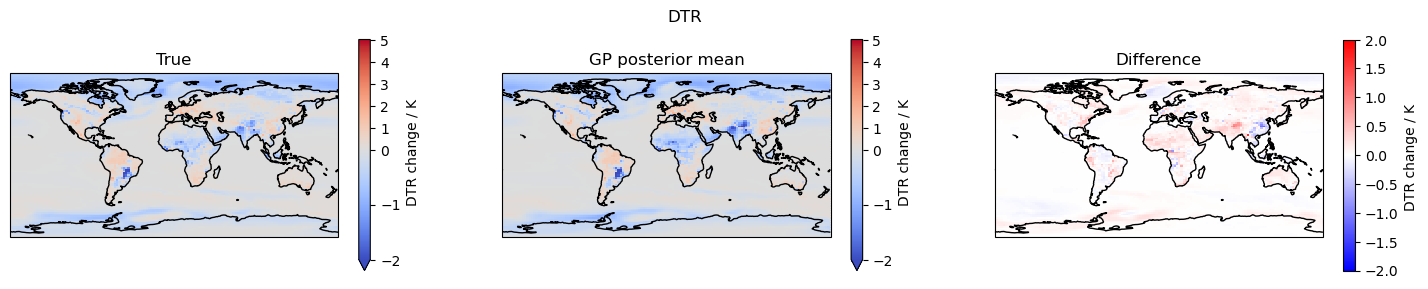

In [13]:
from matplotlib import colors
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('DTR')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_dtr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = dtr_truth - posterior_dtr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [14]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.20785411]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2.54138
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,5.2194
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.06593512409548839
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.48763960832641695
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.14007659238349016
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.02441118, 4.50587, 1.35779..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.3117402754966986
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[5.80576, 4.24049, 8.60169..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.3264734783071516
